In [149]:
import os
import pandas as pd

from autoconfig import AutoConfig
config_file_name = "config.ini"
script_path = os.getcwd()

conf_file = os.path.join(script_path, config_file_name)
conf = AutoConfig(conf_file)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
train_path = os.path.join(conf.path.input_path, "train.csv.zip")
test_path = os.path.join(conf.path.input_path, "test.csv.zip")
conf.path.word_vectors_path = os.path.join(conf.path.input_path, "wiki.ru.vec") # bunch of russian w2v http://rusvectores.org/en/models/

In [163]:
train = pd.read_csv(train_path,compression="zip",nrows = 5000)
test = pd.read_csv(test_path,compression="zip",nrows = 5000)

In [164]:
from pipeline import Pipeline

In [165]:
pi = Pipeline(conf, train, test)

In [226]:
vocab, mat, train_cont, test_cont, target = pi.pipe()

loading vectors..
preparing data...
cleaning text...
3058 words were found over a vocab of 4000 which is a ratio of 0.76


In [227]:
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, Reshape
from keras.layers.merge import concatenate
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D , GlobalAveragePooling1D, AveragePooling1D
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.initializers import RandomUniform

import numpy as np

def CatEmbLayer(nb_category, CATEGORY_EMB_DIM,
                input_of_layer, drop_out = 0.2):
    uniform = RandomUniform(
                        minval=-np.sqrt(3/CATEGORY_EMB_DIM),  # Suggested by
                        maxval= np.sqrt(3/CATEGORY_EMB_DIM))
    
    category_emb = Embedding(input_dim=nb_category,
                        output_dim = CATEGORY_EMB_DIM,
                        input_length = 1,
                        trainable = True, 
                        embeddings_initializer=uniform )(input_of_layer)
    category_emb = Reshape((CATEGORY_EMB_DIM, ))(category_emb)
    category_emb = Dropout(drop_out)(category_emb)
    return category_emb

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.pow(y_pred-y_true, 2)))


##### MODEL
text_input = Input((conf.data_prep.pad_len_word, ))
other_feat_input = Input((train_cont["other_feat"][0].shape[1], ))

category_input = Input((1, )) #https://arxiv.org/abs/1604.06737
sub_category_input = Input((1, ))
parent_cat_input = Input((1, ))
region_cat_input = Input((1, ))
city_cat_input = Input((1, ))
image_cat_input = Input((1, ))
user_cat_input = Input((1, ))
day_cat_input = Input((1, ))


m = Embedding(input_dim = conf.data_prep.max_vocab + 1 ,
              output_dim =  conf.data_prep.emb_dim,
              weights=[mat],
              input_length=conf.data_prep.pad_len_word,
              trainable=False)(text_input)

m = Dropout(0.5)(m)
m = Conv1D(int(conf.modelling.num_filters),
           int(conf.modelling.filter_size),
           activation='relu', padding='same')(m)

m = AveragePooling1D(2)(m)

m = Conv1D(conf.modelling.num_filters - 4, conf.modelling.filter_size,
           activation='relu',
           padding='same')(m)
m = GlobalAveragePooling1D()(m)

category_emb = CatEmbLayer(train_cont['cat_s']['cat'], conf.modelling.category_emb_dim, category_input)
parent_cat_emb = CatEmbLayer(train_cont['cat_s']["parent_cat"], conf.modelling.category_emb_dim, parent_cat_input)
region_cat_emb = CatEmbLayer(train_cont['cat_s']["region_cat"], conf.modelling.category_emb_dim, region_cat_input)
city_cat_emb = CatEmbLayer(train_cont['cat_s']["city_cat"], conf.modelling.category_emb_dim, city_cat_input)
image_cat_emb = CatEmbLayer(train_cont['cat_s']["image_cat"], conf.modelling.category_emb_dim, image_cat_input)
user_cat_emb = CatEmbLayer(train_cont['cat_s']["user_cat"], conf.modelling.category_emb_dim, user_cat_input)
day_cat_emb = CatEmbLayer(train_cont['cat_s']["day_cat"], conf.modelling.category_emb_dim, day_cat_input)

m = concatenate([category_emb,
                 parent_cat_emb,
                 region_cat_emb,
                 city_cat_emb,
                 image_cat_emb,
                 user_cat_emb,
                 day_cat_emb,
                 other_feat_input,
                 m], axis = 1)

m = BatchNormalization()(m)

m = Dense(35, activation='relu')(m)

m = Dropout(0.1)(m)

m = Dense(5, activation='relu', kernel_regularizer=regularizers.l2(conf.modelling.weight_decay))(m)

output = Dense(1)(m)


model = Model(inputs=[category_input,
                      parent_cat_input,
                      region_cat_input,
                      city_cat_input,
                      image_cat_input,
                      user_cat_input,
                      day_cat_input,
                      other_feat_input,
                      text_input] , 
              outputs= output,
              name='sec_model')
adam = optimizers.Adam(lr=0.0001, beta_1=0.9,
                       beta_2=0.999, epsilon=1e-08,
                       decay=0.01, clipnorm=2.)
model.compile(loss='mean_squared_error', #mean squared error might drop to 0 faster than expected
              optimizer=adam,
              metrics=[rmse, "mae"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_254 (InputLayer)          (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_81 (Embedding)        (None, 35, 300)      1200300     input_254[0][0]                  
__________________________________________________________________________________________________
dropout_87 (Dropout)            (None, 35, 300)      0           embedding_81[0][0]               
__________________________________________________________________________________________________
input_256 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_258 

In [228]:
#early_stopping = EarlyStopping(monitor='val_rmse', min_delta=0.01, patience=7, verbose=1)
#callbacks_list = [early_stopping]




target = np.array(train.deal_probability)

hist = model.fit(train_cont['cat_d']['cat_data'] + train_cont['cat_d']["parent_data"] +\
                 train_cont['cat_d']["region_data"] + train_cont['cat_d']["city_data"] + train_cont['cat_d']["image_data"] +\
                 train_cont['cat_d']["user_data"] + train_cont['cat_d']["day_data"] + train_cont["other_feat"]  + \
                 [padded_words] ,
                 target,
                 batch_size=conf.modelling.batch_size,
                 epochs=3,# conf.modelling.num_epochs
                 validation_split = 0.1,
                 shuffle=True,
                 verbose=2, 
                # callbacks = callbacks_list
                )

Train on 4500 samples, validate on 500 samples
Epoch 1/3
 - 6s - loss: 0.6454 - rmse: 0.7911 - mean_absolute_error: 0.6033 - val_loss: 0.3184 - val_rmse: 0.5552 - val_mean_absolute_error: 0.4187
Epoch 2/3
 - 4s - loss: 0.4515 - rmse: 0.6641 - mean_absolute_error: 0.4966 - val_loss: 0.2401 - val_rmse: 0.4823 - val_mean_absolute_error: 0.3613
Epoch 3/3
 - 4s - loss: 0.3876 - rmse: 0.6139 - mean_absolute_error: 0.4573 - val_loss: 0.2101 - val_rmse: 0.4514 - val_mean_absolute_error: 0.3363


In [230]:
preds = model.predict(
                 test_cont['cat_d']['cat_data'] + test_cont['cat_d']["parent_data"] +\
                 test_cont['cat_d']["region_data"] + test_cont['cat_d']["city_data"] + test_cont['cat_d']["image_data"] +\
                 test_cont['cat_d']["user_data"] + test_cont['cat_d']["day_data"] + test_cont["other_feat"]  + \
                 [padded_test] ,
)

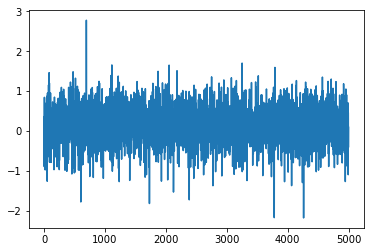

In [236]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(preds.flatten())

In [225]:
# need to build category mappig based on test and train

In [223]:
padded_words = sequence.pad_sequences(train_cont['indexes']["word_id"], maxlen = conf.data_prep.pad_len_word)
padded_test = sequence.pad_sequences(test_cont['indexes']["word_id"], maxlen = conf.data_prep.pad_len_word)

In [207]:
padded_words.shape

(5000, 35)

In [217]:
np.max(padded_words)

4000